## 3. Zmodyfikowany AES, dyfuzja, konfuzja, słabe klucze

### Zmodyfikowany AES, wyświetla pośredni wynik w każej z rund w postaci binarnej

In [2]:
# -*- coding: utf-8 -*-
"""AES

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1JEOROhLRai6ndhXi-MLHspJFAlsqCA01
"""

#!/usr/bin/python2.5
# Copyright (c) 2007 Brandon Sterne
# Licensed under the MIT license.
# http://brandon.sternefamily.net/files/mit-license.txt
# Python AES implementation

import sys, hashlib, string, getpass
from copy import copy
from random import randint

# The actual Rijndael specification includes variable block size, but
# AES uses a fixed block size of 16 bytes (128 bits)

# Additionally, AES allows for a variable key size, though this implementation
# of AES uses only 256-bit cipher keys (AES-256)

sbox = [
        0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
        0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
        0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
        0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
        0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
        0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
        0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
        0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
        0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
        0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
        0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
        0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
        0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
        0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
        0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
        0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
        ]

sboxInv = [
        0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3, 0x9e, 0x81, 0xf3, 0xd7, 0xfb,
        0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f, 0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb,
        0x54, 0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b, 0x42, 0xfa, 0xc3, 0x4e,
        0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24, 0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25,
        0x72, 0xf8, 0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d, 0x65, 0xb6, 0x92,
        0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda, 0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84,
        0x90, 0xd8, 0xab, 0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3, 0x45, 0x06,
        0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1, 0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b,
        0x3a, 0x91, 0x11, 0x41, 0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6, 0x73,
        0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9, 0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e,
        0x47, 0xf1, 0x1a, 0x71, 0x1d, 0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b,
        0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0, 0xfe, 0x78, 0xcd, 0x5a, 0xf4,
        0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07, 0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f,
        0x60, 0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f, 0x93, 0xc9, 0x9c, 0xef,
        0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5, 0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61,
        0x17, 0x2b, 0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0c, 0x7d
        ]

rcon = [
        0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a,
        0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39,
        0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a,
        0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8,
        0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef,
        0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc,
        0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b,
        0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3,
        0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94,
        0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20,
        0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35,
        0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f,
        0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04,
        0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63,
        0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd,
        0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb
        ]

# returns a copy of the word shifted n bytes (chars)
# positive values for n shift bytes left, negative values shift right
def rotate(word, n):
    return word[n:]+word[0:n]

# iterate over each "virtual" row in the state table and shift the bytes
# to the LEFT by the appropriate offset
def shiftRows(state):
    for i in range(4):
        state[i*4:i*4+4] = rotate(state[i*4:i*4+4],i)

# iterate over each "virtual" row in the state table and shift the bytes
# to the RIGHT by the appropriate offset
def shiftRowsInv(state):
    for i in range(4):
        state[i*4:i*4+4] = rotate(state[i*4:i*4+4],-i)

# takes 4-byte word and iteration number
def keyScheduleCore(word, i):
    # rotate word 1 byte to the left
    word = rotate(word, 1)
    newWord = []
    # apply sbox substitution on all bytes of word
    for byte in word:
        newWord.append(sbox[byte])
    # XOR the output of the rcon[i] transformation with the first part of the word
    newWord[0] = newWord[0]^rcon[i]
    return newWord

# expand 256 bit cipher key into 240 byte key from which
# each round key is derived
def expandKey(cipherKey):
    cipherKeySize = len(cipherKey)
    assert cipherKeySize == 32
    # container for expanded key
    expandedKey = []
    currentSize = 0
    rconIter = 1
    # temporary list to store 4 bytes at a time
    t = [0,0,0,0]

    # copy the first 32 bytes of the cipher key to the expanded key
    for i in range(cipherKeySize):
        expandedKey.append(cipherKey[i])
    currentSize += cipherKeySize

    # generate the remaining bytes until we get a total key size
    # of 240 bytes
    while currentSize < 240:
        # assign previous 4 bytes to the temporary storage t
        for i in range(4):
            t[i] = expandedKey[(currentSize - 4) + i]

        # every 32 bytes apply the core schedule to t
        if currentSize % cipherKeySize == 0:
            t = keyScheduleCore(t, rconIter)
            rconIter += 1

        # since we're using a 256-bit key -> add an extra sbox transform
        if currentSize % cipherKeySize == 16:
            for i in range(4):
                t[i] = sbox[t[i]]

        # XOR t with the 4-byte block [16,24,32] bytes before the end of the
        # current expanded key.  These 4 bytes become the next bytes in the
        # expanded key
        for i in range(4):
            expandedKey.append(((expandedKey[currentSize - cipherKeySize]) ^ (t[i])))
            currentSize += 1

    return expandedKey

# do sbox transform on each of the values in the state table
def  subBytes(state):
    for i in range(len(state)):
        #print "state[i]:", state[i]
        #print "sbox[state[i]]:", sbox[state[i]]
        state[i] = sbox[state[i]]

# inverse sbox transform on each byte in state table
def subBytesInv(state):
    for i in range(len(state)):
        state[i] = sboxInv[state[i]]

# XOR each byte of the roundKey with the state table
def addRoundKey(state, roundKey):
    for i in range(len(state)):
        #print i
        #print "old state value:", state[i]
        #print "new state value:", state[i] ^ roundKey[i]
        state[i] = state[i] ^ roundKey[i]

# Galois Multiplication
def galoisMult(a, b):
    p = 0
    hiBitSet = 0
    for i in range(8):
        if b & 1 == 1:
            p ^= a
        hiBitSet = a & 0x80
        a <<= 1
        if hiBitSet == 0x80:
            a ^= 0x1b
        b >>= 1
    return p % 256

# mixColumn takes a column and does stuff
def mixColumn(column):
    temp = copy(column)
    column[0] = galoisMult(temp[0],2) ^ galoisMult(temp[3],1) ^ \
                galoisMult(temp[2],1) ^ galoisMult(temp[1],3)
    column[1] = galoisMult(temp[1],2) ^ galoisMult(temp[0],1) ^ \
                galoisMult(temp[3],1) ^ galoisMult(temp[2],3)
    column[2] = galoisMult(temp[2],2) ^ galoisMult(temp[1],1) ^ \
                galoisMult(temp[0],1) ^ galoisMult(temp[3],3)
    column[3] = galoisMult(temp[3],2) ^ galoisMult(temp[2],1) ^ \
                galoisMult(temp[1],1) ^ galoisMult(temp[0],3)

# mixColumnInv does stuff too
def mixColumnInv(column):
    temp = copy(column)
    column[0] = galoisMult(temp[0],14) ^ galoisMult(temp[3],9) ^ \
                galoisMult(temp[2],13) ^ galoisMult(temp[1],11)
    column[1] = galoisMult(temp[1],14) ^ galoisMult(temp[0],9) ^ \
                galoisMult(temp[3],13) ^ galoisMult(temp[2],11)
    column[2] = galoisMult(temp[2],14) ^ galoisMult(temp[1],9) ^ \
                galoisMult(temp[0],13) ^ galoisMult(temp[3],11)
    column[3] = galoisMult(temp[3],14) ^ galoisMult(temp[2],9) ^ \
                galoisMult(temp[1],13) ^ galoisMult(temp[0],11)

# mixColumns is a wrapper for mixColumn - generates a "virtual" column from
# the state table and applies the weird galois math
def mixColumns(state):
    for i in range(4):
        column = []
        # create the column by taking the same item out of each "virtual" row
        for j in range(4):
            column.append(state[j*4+i])

        # apply mixColumn on our virtual column
        mixColumn(column)

        # transfer the new values back into the state table
        for j in range(4):
            state[j*4+i] = column[j]

# mixColumnsInv is a wrapper for mixColumnInv - generates a "virtual" column from
# the state table and applies the weird galois math
def mixColumnsInv(state):
    for i in range(4):
        column = []
        # create the column by taking the same item out of each "virtual" row
        for j in range(4):
            column.append(state[j*4+i])

        # apply mixColumn on our virtual column
        mixColumnInv(column)

        # transfer the new values back into the state table
        for j in range(4):
            state[j*4+i] = column[j]

# aesRound applies each of the four transformations in order
def aesRound(state, roundKey):
    #print "aesRound - before subBytes:", state
    subBytes(state)
    #print "aesRound - before shiftRows:", state
    shiftRows(state)
    #print "aesRound - before mixColumns:", state
    mixColumns(state)
    #print "aesRound - before addRoundKey:", state
    addRoundKey(state, roundKey)
    #print "aesRound - after addRoundKey:", state

# aesRoundInv applies each of the four inverse transformations
def aesRoundInv(state, roundKey):
    #print "aesRoundInv - before addRoundKey:", state
    addRoundKey(state, roundKey)
    #print "aesRoundInv - before mixColumnsInv:", state
    mixColumnsInv(state)
    #print "aesRoundInv - before shiftRowsInv:", state
    shiftRowsInv(state)
    #print "aesRoundInv - before subBytesInv:", state
    subBytesInv(state)
    #print "aesRoundInv - after subBytesInv:", state


# returns a 16-byte round key based on an expanded key and round number
def createRoundKey(expandedKey, n):
    return expandedKey[(n*16):(n*16+16)]

# create a key from a user-supplied password using SHA-256
def passwordToKey(password):
    sha256 = hashlib.sha256()
    sha256.update(password)
    key = []
    for c in list(sha256.digest()):
        key.append(ord(c))
    return key

def state_to_binary_string(state):
    return ' '.join(format(byte, '08b') for byte in state)

# wrapper function for 14 rounds of AES since we're using a 256-bit key
def aesMain(state, expandedKey, numRounds=14):
    rounds = []
    roundKey = createRoundKey(expandedKey, 0)
    addRoundKey(state, roundKey)
    rounds.append(state_to_binary_string(state))
    for i in range(1, numRounds):
        roundKey = createRoundKey(expandedKey, i)
        aesRound(state, roundKey)
        rounds.append(state_to_binary_string(state))
    # final round - leave out the mixColumns transformation
    roundKey = createRoundKey(expandedKey, numRounds)
    subBytes(state)
    shiftRows(state)
    addRoundKey(state, roundKey)
    rounds.append(state_to_binary_string(state))
    return rounds

# 14 rounds of AES inverse since we're using a 256-bit key
def aesMainInv(state, expandedKey, numRounds=14):
    # create roundKey for "last" round since we're going in reverse
    roundKey = createRoundKey(expandedKey, numRounds)
    # addRoundKey is the same funtion for inverse since it uses XOR
    addRoundKey(state, roundKey)
    shiftRowsInv(state)
    subBytesInv(state)
    for i in range(numRounds-1,0,-1):
        roundKey = createRoundKey(expandedKey, i)
        aesRoundInv(state, roundKey)
    # last round - leave out the mixColumns transformation
    roundKey = createRoundKey(expandedKey, 0)
    addRoundKey(state, roundKey)


# aesEncrypt - encrypt a single block of plaintext
def aesEncrypt(plaintext, key):
    block = copy(plaintext)
    expandedKey = expandKey(key)
    rounds = aesMain(block, expandedKey)
    return block, rounds

# aesDecrypt - decrypte a single block of ciphertext
def aesDecrypt(ciphertext, key):
    block = copy(ciphertext)
    expandedKey = expandKey(key)
    aesMainInv(block, expandedKey)
    return block




In [3]:
key = [0] * 32
plaintext = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ciphertext, rounds0 = aesEncrypt(plaintext, key)
decrypted = aesDecrypt(ciphertext, key)

print("Plaintext: ",plaintext)
for i, round in enumerate(rounds0):
    print("Round: ", i, round)

print("Ciphertext: ", ciphertext)
print("Decrypted: ", decrypted)

Plaintext:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Round:  0 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000000
Round:  1 01100011 01100011 01100011 01100011 01100011 01100011 01100011 01100011 01100011 01100011 01100011 01100011 01100011 01100011 01100011 01100011
Round:  2 10011001 10011000 10011000 10011000 10011001 10011000 10011000 10011000 10011001 10011000 10011000 10011000 10011001 10011000 10011000 10011000
Round:  3 10100111 00010101 00010101 01011110 01000100 00010101 01011110 11110110 01000100 01011110 11110110 00010101 00001111 11110110 00010101 00010101
Round:  4 00100111 00011001 01000001 01010011 01111100 01111011 10111101 01110011 00000101 01000101 10000111 11010111 01000000 00001001 00111001 10110101
Round:  5 01011111 10110111 01110000 11100111 10110101 01001101 01001100 11111100 11011010 00100100 01010100 01111101 00011111 01110111 00001110 11100111
Round:  6 01011

### Wyniki dyfuzji i konfuzji obliczone w następujący sposób:
- każdy bit wiadomości lub klucza po kolei negujemy
- w każdej iteracji liczymy ile bitów różni, między szyfrem z oryginału a tym po zmianie (po 1, 2 ... 14 rundach)
- liczymy średni wynik dzieląc sumę różniących się bitów dla każdej rundy przez 64 (długość wiadomości lub klucza)

In [4]:
def count_different_bits(str1, str2):
    str1 = str1.replace(" ", "")
    str2 = str2.replace(" ", "")
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

def analyze_diffusion_confusion(base_plaintext, base_key, is_key_analysis=False):

    num_bits = 128  
    rounds_changes = [0] * 15  
    
    
    _, base_rounds = aesEncrypt(base_plaintext, base_key)
    
    for bit_pos in range(num_bits):
        byte_pos = bit_pos // 8
        bit_in_byte = bit_pos % 8
        
        if is_key_analysis:
            test_key = base_key.copy()
            test_key[byte_pos] ^= (1 << bit_in_byte)
            test_plaintext = base_plaintext.copy()
        else:
            test_key = base_key.copy()
            test_plaintext = base_plaintext.copy()
            test_plaintext[byte_pos] ^= (1 << bit_in_byte)
            
        _, test_rounds = aesEncrypt(test_plaintext, test_key)
        

        for round_idx in range(len(test_rounds)):
            diff_bits = count_different_bits(test_rounds[round_idx], base_rounds[round_idx])
            rounds_changes[round_idx] += diff_bits
    
    avg_changes = [changes / num_bits for changes in rounds_changes]
    return avg_changes

def analysis_main(base_key, base_plaintext):
    print("Analyzing plaintext changes (diffusion):")
    diffusion_results = analyze_diffusion_confusion(base_plaintext, base_key, is_key_analysis=False)
    for round_idx, avg_changes in enumerate(diffusion_results):
        print(f"Round {round_idx}: Average bits changed = {avg_changes:.2f} ({(avg_changes/128)*100:.1f}%)")
    
    diffusion_percentages = [r/128*100 for r in diffusion_results]

    print("\nAnalyzing key changes (confusion):")
    confusion_results = analyze_diffusion_confusion(base_plaintext, base_key, is_key_analysis=True)
    for round_idx, avg_changes in enumerate(confusion_results):
        print(f"Round {round_idx}: Average bits changed = {avg_changes:.2f} ({(avg_changes/128)*100:.1f}%)")

    confusion_percentages = [r/128*100 for r in confusion_results]
    
    return diffusion_percentages, confusion_percentages

def plot_avalanche_effects(diffusion_results, confusion_results):
    try:
        import matplotlib.pyplot as plt
        
        rounds = range(1, len(diffusion_results) + 1)
        diff_percentages = [r for r in diffusion_results]
        conf_percentages = [r for r in confusion_results]
        
        plt.figure(figsize=(10, 6))
        plt.plot(rounds, diff_percentages, 'b-', label='Diffusion')
        plt.plot(rounds, conf_percentages, 'r-', label='Confusion')
        plt.axhline(y=50, color='g', linestyle='--', label='Ideal (50%)')
        
        plt.xlabel('Round')
        plt.ylabel('Average Bit Changes (%)')
        plt.title('Avalanche Effect Analysis')
        plt.legend()
        plt.grid(True)
        plt.show()
    except ImportError:
        print("Matplotlib is not installed. Skipping visualization.")

Analyzing plaintext changes (diffusion):
Round 0: Average bits changed = 1.00 (0.8%)
Round 1: Average bits changed = 15.88 (12.4%)
Round 2: Average bits changed = 65.12 (50.9%)
Round 3: Average bits changed = 63.38 (49.5%)
Round 4: Average bits changed = 63.20 (49.4%)
Round 5: Average bits changed = 64.48 (50.4%)
Round 6: Average bits changed = 64.27 (50.2%)
Round 7: Average bits changed = 63.89 (49.9%)
Round 8: Average bits changed = 63.77 (49.8%)
Round 9: Average bits changed = 64.73 (50.6%)
Round 10: Average bits changed = 64.25 (50.2%)
Round 11: Average bits changed = 64.45 (50.4%)
Round 12: Average bits changed = 63.84 (49.9%)
Round 13: Average bits changed = 64.29 (50.2%)
Round 14: Average bits changed = 64.98 (50.8%)

Analyzing key changes (confusion):
Round 0: Average bits changed = 1.00 (0.8%)
Round 1: Average bits changed = 15.88 (12.4%)
Round 2: Average bits changed = 64.75 (50.6%)
Round 3: Average bits changed = 63.88 (49.9%)
Round 4: Average bits changed = 63.77 (49.8%)
Ro

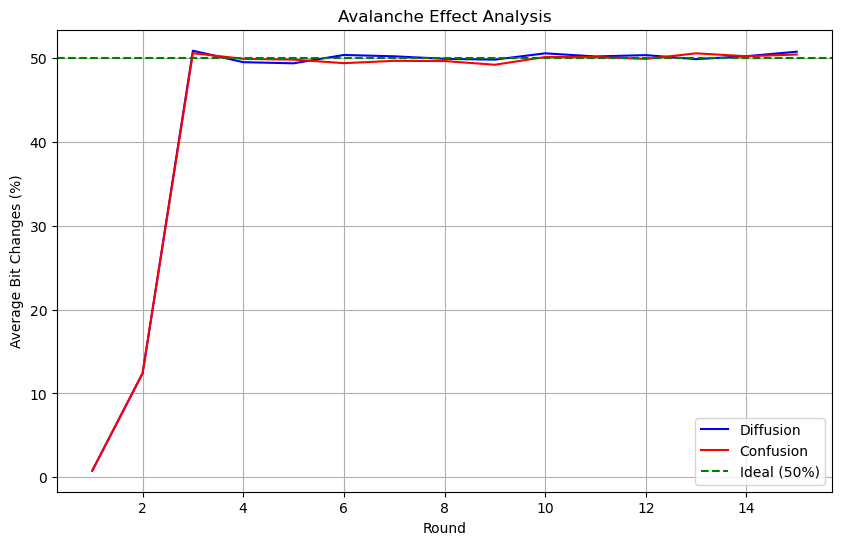

In [5]:
base_key = [0] * 32
base_plaintext = [0] * 16

diffusion_results, confusion_results = analysis_main(base_key, base_plaintext)
plot_avalanche_effects(diffusion_results, confusion_results)

### AES nie posiada matematycznie udowodnionych słabych kluczy

### 4. AES z innym wielomianem
(x⁸ + x⁵ + x³ + x² + 1) (0x169)
Nowe wartości SBox są wyliczone przez rozwiązanie tego wielomianu w przestrzeni Galois

In [16]:
sbox = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
]

sboxInv = [
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D
]

rcon = [
    0x8d, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1d, 0x3a, 0x74, 0xe8, 0x1f, 0x3e, 0x7c, 0xf8,
    0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e,
    0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0,
    0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c,
    0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f,
    0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c,
    0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f,
    0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78,
    0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e,
    0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8,
    0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e,
    0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0,
    0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c,
    0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f,
    0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c,
    0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0, 0x1f, 0x3e, 0x7c, 0xf8, 0x0f, 0x1e, 0x3c, 0x78, 0xf0
]


def galoisMultCustom(a, b, polynomial=0x11B):
    p = 0
    hiBitSet = 0
    for i in range(8):
        if b & 1 == 1:
            p ^= a
        hiBitSet = a & 0x80
        a <<= 1
        if hiBitSet == 0x80:
            a ^= polynomial
        b >>= 1
    return p % 256


def mixColumnCustom(column, polynomial=0x11B):
    temp = copy(column)
    column[0] = galoisMultCustom(temp[0], 2, polynomial) ^ galoisMultCustom(temp[3], 1, polynomial) ^ \
                galoisMultCustom(temp[2], 1, polynomial) ^ galoisMultCustom(temp[1], 3, polynomial)
    column[1] = galoisMultCustom(temp[1], 2, polynomial) ^ galoisMultCustom(temp[0], 1, polynomial) ^ \
                galoisMultCustom(temp[3], 1, polynomial) ^ galoisMultCustom(temp[2], 3, polynomial)
    column[2] = galoisMultCustom(temp[2], 2, polynomial) ^ galoisMultCustom(temp[1], 1, polynomial) ^ \
                galoisMultCustom(temp[0], 1, polynomial) ^ galoisMultCustom(temp[3], 3, polynomial)
    column[3] = galoisMultCustom(temp[3], 2, polynomial) ^ galoisMultCustom(temp[2], 1, polynomial) ^ \
                galoisMultCustom(temp[1], 1, polynomial) ^ galoisMultCustom(temp[0], 3, polynomial)

def mixColumnInvCustom(column, polynomial=0x11B):
    temp = copy(column)
    column[0] = galoisMultCustom(temp[0], 14, polynomial) ^ galoisMultCustom(temp[3], 9, polynomial) ^ \
                galoisMultCustom(temp[2], 13, polynomial) ^ galoisMultCustom(temp[1], 11, polynomial)
    column[1] = galoisMultCustom(temp[1], 14, polynomial) ^ galoisMultCustom(temp[0], 9, polynomial) ^ \
                galoisMultCustom(temp[3], 13, polynomial) ^ galoisMultCustom(temp[2], 11, polynomial)
    column[2] = galoisMultCustom(temp[2], 14, polynomial) ^ galoisMultCustom(temp[1], 9, polynomial) ^ \
                galoisMultCustom(temp[0], 13, polynomial) ^ galoisMultCustom(temp[3], 11, polynomial)
    column[3] = galoisMultCustom(temp[3], 14, polynomial) ^ galoisMultCustom(temp[2], 9, polynomial) ^ \
                galoisMultCustom(temp[1], 13, polynomial) ^ galoisMultCustom(temp[0], 11, polynomial)

def mixColumnsCustom(state, polynomial=0x11B):
    for i in range(4):
        column = []
        for j in range(4):
            column.append(state[j*4+i])
        mixColumnCustom(column, polynomial)
        for j in range(4):
            state[j*4+i] = column[j]

def mixColumnsInvCustom(state, polynomial=0x11B):
    for i in range(4):
        column = []
        for j in range(4):
            column.append(state[j*4+i])
        mixColumnInvCustom(column, polynomial)
        for j in range(4):
            state[j*4+i] = column[j]

def test_custom_polynomial(plaintext, key, custom_poly):
    
    def aesMain_custom(state, expandedKey, polynomial, numRounds=14):
        rounds = []
        roundKey = createRoundKey(expandedKey, 0)
        addRoundKey(state, roundKey)
        rounds.append(state_to_binary_string(state))
        
        for i in range(1, numRounds):
            roundKey = createRoundKey(expandedKey, i)
            subBytes(state)
            shiftRows(state)
            mixColumnsCustom(state, polynomial)
            addRoundKey(state, roundKey)
            rounds.append(state_to_binary_string(state))
            
        roundKey = createRoundKey(expandedKey, numRounds)
        subBytes(state)
        shiftRows(state)
        addRoundKey(state, roundKey)
        rounds.append(state_to_binary_string(state))
        return rounds

    def aesMainInv_custom(state, expandedKey, polynomial, numRounds=14):
        roundKey = createRoundKey(expandedKey, numRounds)
        addRoundKey(state, roundKey)
        shiftRowsInv(state)
        subBytesInv(state)
        
        for i in range(numRounds-1, 0, -1):
            roundKey = createRoundKey(expandedKey, i)
            addRoundKey(state, roundKey)
            mixColumnsInvCustom(state, polynomial)
            shiftRowsInv(state)
            subBytesInv(state)
            
        roundKey = createRoundKey(expandedKey, 0)
        addRoundKey(state, roundKey)

    def aesEncrypt_custom(plaintext, key, polynomial):
        block = copy(plaintext)
        expandedKey = expandKey(key)
        rounds = aesMain_custom(block, expandedKey, polynomial)
        return block, rounds

    def aesDecrypt_custom(ciphertext, key, polynomial):
        block = copy(ciphertext)
        expandedKey = expandKey(key)
        aesMainInv_custom(block, expandedKey, polynomial)
        return block

    ciphertext, rounds = aesEncrypt_custom(plaintext, key, custom_poly)
    decrypted = aesDecrypt_custom(ciphertext, key, custom_poly)

    print("Custom polynomial AES test:")
    print("Plaintext:", plaintext)
    for i, round in enumerate(rounds):
        print("Round: ", i, round)
    print("Ciphertext:", ciphertext)
    print("Decrypted:", decrypted)
    
    return rounds



In [19]:
key = [0] * 32
plaintext = [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
custom_poly = 0x169

test_rounds = test_custom_polynomial(plaintext, key, custom_poly)

Custom polynomial AES test:
Plaintext: [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Round:  0 00000001 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000001 00000000 00000000 00000000 00000000 00000000 00000000
Round:  1 01011101 01100011 01100011 01111100 01111100 01100011 01100011 01000010 01111100 01100011 01100011 01011101 01000010 01100011 01100011 01111100
Round:  2 01110110 11111000 01100011 01110011 11000110 11111111 00001011 11001100 01111001 10001111 11110000 10011000 10010101 11101000 10100100 00100111
Round:  3 11100101 01101000 10010100 00000011 11001010 00001100 10111110 10101001 10001101 01100011 10001010 11111101 11001100 00000001 00111101 01010110
Round:  4 00010101 01100010 00010101 00001010 01110100 11001000 01111001 00001111 00001011 11110010 10100011 01000101 10000010 10101100 00011111 10010011
Round:  5 11110001 01111110 00011111 00111101 00001001 01111000 00101111 10000110 01101100 01111000 00101110 11000010 11110011 00011111 100010

Analyzing plaintext changes (diffusion):
Round 0: Average bits changed = 1.00 (0.8%)
Round 1: Average bits changed = 15.88 (12.4%)
Round 2: Average bits changed = 65.12 (50.9%)
Round 3: Average bits changed = 64.69 (50.5%)
Round 4: Average bits changed = 63.84 (49.9%)
Round 5: Average bits changed = 64.98 (50.8%)
Round 6: Average bits changed = 64.26 (50.2%)
Round 7: Average bits changed = 63.63 (49.7%)
Round 8: Average bits changed = 63.56 (49.7%)
Round 9: Average bits changed = 64.62 (50.5%)
Round 10: Average bits changed = 65.17 (50.9%)
Round 11: Average bits changed = 64.30 (50.2%)
Round 12: Average bits changed = 63.75 (49.8%)
Round 13: Average bits changed = 64.31 (50.2%)
Round 14: Average bits changed = 64.80 (50.6%)

Analyzing key changes (confusion):
Round 0: Average bits changed = 1.00 (0.8%)
Round 1: Average bits changed = 15.88 (12.4%)
Round 2: Average bits changed = 64.75 (50.6%)
Round 3: Average bits changed = 64.12 (50.1%)
Round 4: Average bits changed = 64.38 (50.3%)
Ro

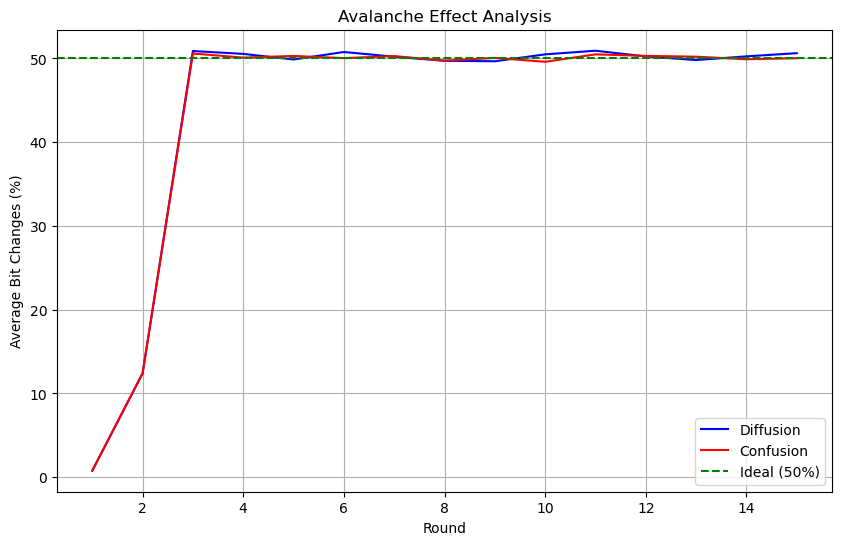

In [20]:
base_key = [0] * 32
base_plaintext = [0] * 16

diffusion_results, confusion_results = analysis_main(base_key, base_plaintext)
plot_avalanche_effects(diffusion_results, confusion_results)

## 5. Poziom bezpieczeństwa

Poziom bezpieczeństwa w jako podłoga(log2(liczba kombinacji)) nie ulega zmianie (długość klucza się nie zmienia). Wyniki konfuzji i dyfuzji również nie wykazują znaczącej różnicy w stosunku do oryginału